#Mount

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/EVA2/Assignment2 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/EVA2/Assignment2


#Imports 

In [8]:
from zipfile import ZipFile
import os
from tqdm.notebook import tqdm
import shutil
import torch
import torchvision
import cudas
import general_utils
from Transform_utils.transforme_album import Data
import general_utils
from models.imagenet import mobilenetv2
import torch.nn as nn

In [3]:
!pip install torch-lr-finder
!pip install torch-lr-finder -v --global-option="amp"

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-ed3bvft7
Created temporary directory: /tmp/pip-req-tracker-uu14npz7
Created requirements tracker '/tmp/pip-req-tracker-uu14npz7'
Created temporary directory: /tmp/pip-install-z503j87o
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-uu14npz7'


#Unzip

In [9]:
!unzip -q /content/gdrive/My\ Drive/Dataset.zip -d /content/ZData/

replace /content/ZData/Flying Birds/FlyingBirds_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Count

In [10]:
import os
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Flying Birds/')]))
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Winged Drones/')]))
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Large QuadCopters/')]))
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Small QuadCopters/')]))

8337
5675
4169
3623


#Segregate Train/Val Data

In [11]:
for p,d,f in tqdm(os.walk('/content/ZData/')):
  for d1 in d:
    count = 0
    if not os.path.exists('/content/ZData/Train/'+d1+'/'):
             os.makedirs('/content/ZData/Train/'+d1+'/')
    if not os.path.exists('/content/ZData/Val/'+d1+'/'):
             os.makedirs('/content/ZData/Val/'+d1+'/')
    if d1=='Flying Birds':
            x = 0.7*8337
    elif d1=='Large QuadCopters':
            x = 0.7*4169
    elif d1=='Small QuadCopters':
            x = 0.7*3623
    else:
            x = 0.7*5675
    print(d1, x)
    for p1,d2,f1 in os.walk(p+d1):
        for f2 in f1:
          count=count+1
          if count<x:
            shutil.copy(p1+'/'+f2, '/content/ZData/Train/'+p1.split('/')[-1]+'/')
          else:
            shutil.copy(p1+'/'+f2, '/content/ZData/Val/'+p1.split('/')[-1]+'/')
#!rm -rf /content/ZData/

Small QuadCopters 2536.1
Winged Drones 3972.4999999999995
Large QuadCopters 2918.2999999999997
Flying Birds 5835.9



In [12]:
!rm -rf /content/ZData/Flying\ Birds
!rm -rf /content/ZData/Winged\ Drones
!rm -rf /content/ZData/Large\ QuadCopters
!rm -rf /content/ZData/Small\ QuadCopters

In [13]:
!rm -rf /content/ZData/Train/Large\ QuadCopters/LargeQuadCopters_3643.jpg
!rm -rf /content/ZData/Train/Large\ QuadCopters/LargeQuadCopters_3641.jpg
!rm -rf /content/ZData/Train/Winged\ Drones/WingedDrones_957.jpg
!rm -rf /content/ZData/Val/Winged\ Drones/WingedDrones_4416.jpg
!rm -rf /content/ZData/Val/Large\ QuadCopters/LargeQuadCopters_3573.jpg

In [8]:
import os
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Train/Flying Birds/')]))
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Train/Winged Drones/')]))
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Train/Large QuadCopters/')]))
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Train/Small QuadCopters/')]))
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Val/Flying Birds/')]))
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Val/Winged Drones/')]))
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Val/Large QuadCopters/')]))
print(sum([len(files) for r,d, files in os.walk('/content/ZData/Val/Small QuadCopters/')]))

5835
3972
2918
2536
2502
1703
1251
1087


#Dataset/Dataloader


In [14]:
data = Data()
trainset = data.getTrainDataSet(train=True)
testset =  data.getTestDataSet(train=False)
trainloader = data.getDataLoader(trainset, 128)
trainloader1 = data.getDataLoader(trainset, 4)
testloader = data.getDataLoader(testset, 128)
testloader1 = data.getDataLoader(testset, 4)
classes = ('Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones')

Train Data size 15258
Test Data size 6541


#Display Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])


 Winged Drones
Small QuadCopters
Flying Birds
Small QuadCopters


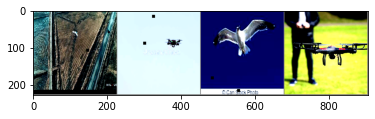

In [10]:
# get some random training images
dataiter = iter(trainloader1)
images, labels = dataiter.next()
print(images.shape)
general_utils.imshow(torchvision.utils.make_grid(images))
print('\n\n','\n'.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
device = torch.device("cuda" if cudas.cuda else "cpu")
net = mobilenetv2().to(device)
net.load_state_dict(torch.load('pretrained_model/mobilenetv2_1.0-0c6065bc.pth'), strict=False)

_IncompatibleKeys(missing_keys=['classifier1.weight', 'classifier1.bias', 'classifier2.weight', 'classifier2.bias'], unexpected_keys=['classifier.weight', 'classifier.bias'])

In [12]:
from torchsummary import summary
summary(net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

#Freeze all layers

In [6]:
# Freeze model weights
for param in net.parameters():
    param.requires_grad = False

In [7]:
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

2,552,836 total parameters.
0 training parameters.


#Unfreeze last 2 layers

In [8]:
for param in net.classifier1.parameters():
    param.requires_grad = True
for param in net.classifier2.parameters():
    param.requires_grad = True

In [9]:
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

2,552,836 total parameters.
328,964 training parameters.


#Finding Min/Max LR

In [13]:
from torch_lr_finder import LRFinder
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0025)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.5)

In [14]:
from tqdm.notebook import tqdm
from Train_Test_utils.traine import train
from Train_Test_utils.teste import test
test_acc = []
train_acc = []
trainloss_ = []
testloss_ = []
lr_ = []
loss=1000
loss1= 1000
for epoch in range(25):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
      lr_.append(param_group['lr'])
    trainacc, loss = train(net, device, trainloader, optimizer, criterion, epoch)
    train_acc.append(trainacc)
    testacc, loss1 = test(net, device, testloader, criterion)
    test_acc.append(testacc)
    trainloss_.append(loss)
    testloss_.append(loss1)
    scheduler.step()
print('Finished Training')

  0%|          | 0/120 [00:00<?, ?it/s]

lr=  0.0001


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 0 Loss=1.388950228691101 Batch_id=1 Accuracy=20.31:   2%|▏         | 2/120 [00:12<16:17,  8.28s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 0 Loss=1.3696271181106567 Batch_id=37 Accuracy=45.31:  32%|███▏      | 38/120 [01:41<02:00,  1.47s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 0 Loss=1.364412546157837 Batch_id=46 Accuracy=41.41:  39%|███▉      | 47/120 [02:08<02:08,  1.77s/it]/usr/

Test Loss= 1.341736 Test Accuracy= 38.25103195230087
lr=  0.00015000000000000001


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 1 Loss=1.315915822982788 Batch_id=2 Accuracy=37.50:   2%|▎         | 3/120 [00:11<10:27,  5.36s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 1 Loss=1.3176966905593872 Batch_id=4 Accuracy=39.06:   4%|▍         | 5/120 [00:16<07:51,  4.10s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 1 Loss=1.2987688779830933 Batch_id=12 Accuracy=39.84:  11%|█         | 13/120 [00:38<03:45,  2.11s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: User

Test Loss= 1.2025685 Test Accuracy= 38.60266014370891
lr=  0.00022500000000000002


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 2 Loss=1.3098278045654297 Batch_id=5 Accuracy=28.91:   5%|▌         | 6/120 [00:18<05:51,  3.09s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 2 Loss=1.133374810218811 Batch_id=48 Accuracy=53.12:  41%|████      | 49/120 [02:10<02:27,  2.08s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 2 Loss=1.1480656862258911 Batch_id=92 Accuracy=50.78:  78%|███████▊  | 93/120 [04:02<00:52,  1.95s/it]/usr

Test Loss= 1.126082 Test Accuracy= 50.61917138052286
lr=  0.0003375


Epoch= 3 Loss=1.065565586090088 Batch_id=7 Accuracy=55.47:   7%|▋         | 8/120 [00:26<04:51,  2.60s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 3 Loss=1.0928616523742676 Batch_id=18 Accuracy=51.56:  16%|█▌        | 19/120 [00:54<03:29,  2.08s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 3 Loss=1.0985852479934692 Batch_id=19 Accuracy=49.22:  17%|█▋        | 20/120 [00:55<02:43,  1.64s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoc

Test Loss= 0.9422673 Test Accuracy= 66.58003363400091
lr=  0.00050625


Epoch= 4 Loss=0.8870533108711243 Batch_id=3 Accuracy=69.53:   3%|▎         | 4/120 [00:14<09:29,  4.91s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 4 Loss=0.8843847513198853 Batch_id=7 Accuracy=69.53:   7%|▋         | 8/120 [00:26<04:49,  2.59s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 4 Loss=0.847996175289154 Batch_id=11 Accuracy=69.53:  10%|█         | 12/120 [00:38<03:36,  2.01s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch=

Test Loss= 0.8870671 Test Accuracy= 77.52637211435561
lr=  0.000759375


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 5 Loss=0.6678465008735657 Batch_id=1 Accuracy=79.69:   2%|▏         | 2/120 [00:14<14:10,  7.21s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 5 Loss=0.6768223643302917 Batch_id=13 Accuracy=80.47:  12%|█▏        | 14/120 [00:45<05:31,  3.13s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 5 Loss=0.6704966425895691 Batch_id=25 Accuracy=75.00:  22%|██▏       | 26/120 [01:11<02:27,  1.57s/it]/us

Test Loss= 0.36056483 Test Accuracy= 78.9481730622229
lr=  0.0011390624999999999


Epoch= 6 Loss=0.5863642692565918 Batch_id=11 Accuracy=79.69:  10%|█         | 12/120 [00:35<03:43,  2.07s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 6 Loss=0.5755402445793152 Batch_id=15 Accuracy=78.91:  13%|█▎        | 16/120 [00:51<04:03,  2.34s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 6 Loss=0.5882251858711243 Batch_id=43 Accuracy=78.12:  37%|███▋      | 44/120 [02:02<03:48,  3.01s/it]/

Test Loss= 0.23800063 Test Accuracy= 80.8439076593793
lr=  0.0017085937499999998


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 7 Loss=0.5331615209579468 Batch_id=15 Accuracy=76.56:  13%|█▎        | 16/120 [00:47<03:50,  2.22s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 7 Loss=0.5153325796127319 Batch_id=51 Accuracy=82.03:  43%|████▎     | 52/120 [02:21<01:49,  1.61s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 7 Loss=0.478359192609787 Batch_id=84 Accuracy=81.25:  71%|███████   | 85/120 [03:49<01:44,  2.99s/it]/u

Test Loss= 0.7234415 Test Accuracy= 81.56245222443052
lr=  0.0025628906249999996


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 8 Loss=0.45345619320869446 Batch_id=3 Accuracy=82.03:   3%|▎         | 4/120 [00:13<08:11,  4.24s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 8 Loss=0.5094547271728516 Batch_id=15 Accuracy=79.69:  13%|█▎        | 16/120 [00:43<02:45,  1.59s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palett

Test Loss= 0.5024029 Test Accuracy= 82.43387861183305
lr=  0.0038443359374999994


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 9 Loss=0.5301008820533752 Batch_id=8 Accuracy=80.47:   8%|▊         | 9/120 [00:27<04:03,  2.19s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 9 Loss=0.3941982388496399 Batch_id=9 Accuracy=82.03:   8%|▊         | 10/120 [00:30<03:59,  2.18s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 9 Loss=0.4935886263847351 Batch_id=18 Accuracy=83.59:  16%|█▌        | 19/120 [00:53<04:21,  2.59s/it]/usr

Test Loss= 0.39071137 Test Accuracy= 82.63262498088977
lr=  0.00576650390625


Epoch= 10 Loss=0.41457903385162354 Batch_id=3 Accuracy=87.50:   3%|▎         | 4/120 [00:13<08:12,  4.24s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 10 Loss=0.357921302318573 Batch_id=5 Accuracy=87.50:   5%|▌         | 6/120 [00:19<06:51,  3.61s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 10 Loss=0.39424294233322144 Batch_id=10 Accuracy=85.16:   9%|▉         | 11/120 [00:30<04:05,  2.26s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
E

Test Loss= 0.4207105 Test Accuracy= 82.61733679865463
lr=  0.008649755859375


Epoch= 11 Loss=0.4070429801940918 Batch_id=2 Accuracy=85.94:   2%|▎         | 3/120 [00:11<10:22,  5.32s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 11 Loss=0.43096545338630676 Batch_id=9 Accuracy=84.38:   8%|▊         | 10/120 [00:37<06:27,  3.52s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 11 Loss=0.39557719230651855 Batch_id=19 Accuracy=84.38:  17%|█▋        | 20/120 [00:54<02:10,  1.31s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "

Test Loss= 0.23513158 Test Accuracy= 83.94740865311114
lr=  0.0129746337890625


Epoch= 12 Loss=0.5773323178291321 Batch_id=3 Accuracy=78.12:   3%|▎         | 4/120 [00:10<05:55,  3.07s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 12 Loss=0.3642756938934326 Batch_id=18 Accuracy=85.94:  16%|█▌        | 19/120 [00:52<03:39,  2.17s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 12 Loss=0.423256516456604 Batch_id=34 Accuracy=83.59:  29%|██▉       | 35/120 [01:38<02:33,  1.81s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
E

Test Loss= 0.5589285 Test Accuracy= 83.41232227488152
lr=  0.01946195068359375


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 13 Loss=0.5606040358543396 Batch_id=37 Accuracy=78.91:  32%|███▏      | 38/120 [01:40<02:08,  1.57s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should

Test Loss= 0.3295349 Test Accuracy= 82.77021862100597
lr=  0.029192926025390625


Epoch= 14 Loss=0.3405960500240326 Batch_id=15 Accuracy=85.94:  13%|█▎        | 16/120 [00:38<02:41,  1.56s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 14 Loss=0.43740785121917725 Batch_id=27 Accuracy=78.12:  23%|██▎       | 28/120 [01:14<03:45,  2.46s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 14 Loss=0.448117733001709 Batch_id=33 Accuracy=85.16:  28%|██▊       | 34/120 [01:28<02:40,  1.87s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 14 Loss=0.3701278865337372 Batch_id=37 Accurac

Test Loss= 0.45849678 Test Accuracy= 81.54716404219538
lr=  0.043789389038085935


Epoch= 15 Loss=0.3997590243816376 Batch_id=23 Accuracy=85.94:  20%|██        | 24/120 [01:02<02:32,  1.59s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 15 Loss=0.3605746328830719 Batch_id=27 Accuracy=85.16:  23%|██▎       | 28/120 [01:11<02:27,  1.61s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 15 Loss=0.6497053503990173 Batch_id=28 Accuracy=81.25:  24%|██▍       | 29/120 [01:16<04:16,  2.81s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 15 Loss=0.4448099732398987 Batch_id=45 Accurac

Test Loss= 0.26815444 Test Accuracy= 83.61106864393824
lr=  0.0656840835571289


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 16 Loss=0.41312772035598755 Batch_id=18 Accuracy=85.94:  16%|█▌        | 19/120 [00:54<03:46,  2.24s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 16 Loss=0.35574448108673096 Batch_id=23 Accuracy=85.94:  20%|██        | 24/120 [01:04<02:43,  1.70s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 16 Loss=0.3430194556713104 Batch_id=26 Accuracy=87.50:  22%|██▎       | 27/120 [01:15<03:29,  2.25s

Test Loss= 0.5611869 Test Accuracy= 80.21709218773888
lr=  0.09852612533569335


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 17 Loss=0.9276638031005859 Batch_id=7 Accuracy=73.44:   7%|▋         | 8/120 [00:28<05:08,  2.76s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 17 Loss=0.7726505398750305 Batch_id=39 Accuracy=81.25:  33%|███▎      | 40/120 [01:47<01:58,  1.48s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 17 Loss=0.6206672191619873 Batch_id=43 Accuracy=83.59:  37%|███▋      | 44/120 [01:57<02:02,  1.61s/it]

Test Loss= 2.926426 Test Accuracy= 62.71212352851246
lr=  0.14778918800354002


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 18 Loss=7.918891906738281 Batch_id=3 Accuracy=22.66:   3%|▎         | 4/120 [00:11<06:30,  3.37s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 18 Loss=1742794381066240.0 Batch_id=29 Accuracy=13.28:  25%|██▌       | 30/120 [01:24<04:07,  2.75s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expresse

Test Loss= nan Test Accuracy= 38.25103195230087
lr=  0.22168378200531003


Epoch= 19 Loss=nan Batch_id=1 Accuracy=32.81:   2%|▏         | 2/120 [00:10<13:28,  6.85s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 19 Loss=nan Batch_id=7 Accuracy=35.16:   7%|▋         | 8/120 [00:26<04:41,  2.51s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 19 Loss=nan Batch_id=14 Accuracy=39.06:  12%|█▎        | 15/120 [00:48<05:57,  3.41s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 19 Loss=nan Batch_id=20 Accuracy=39.06: 

Test Loss= nan Test Accuracy= 38.25103195230087
lr=  0.33252567300796504


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 20 Loss=nan Batch_id=18 Accuracy=37.50:  16%|█▌        | 19/120 [00:53<04:35,  2.72s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 20 Loss=nan Batch_id=45 Accuracy=38.28:  38%|███▊      | 46/120 [02:09<02:29,  2.02s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 20 Loss=nan Batch_id=46 Accuracy=36.72:  39%|███▉      | 47/120 [02:09<01:56,  1.60s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transpar

Test Loss= nan Test Accuracy= 38.25103195230087
lr=  0.49878850951194753


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 21 Loss=nan Batch_id=3 Accuracy=37.50:   3%|▎         | 4/120 [00:13<08:14,  4.26s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 21 Loss=nan Batch_id=7 Accuracy=36.72:   7%|▋         | 8/120 [00:29<06:09,  3.30s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 21 Loss=nan Batch_id=16 Accuracy=39.84:  14%|█▍        | 17/120 [00:49<04:04,  2.38s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency

Test Loss= nan Test Accuracy= 38.25103195230087
lr=  0.7481827642679213


Epoch= 22 Loss=nan Batch_id=7 Accuracy=42.19:   7%|▋         | 8/120 [00:29<05:06,  2.74s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 22 Loss=nan Batch_id=14 Accuracy=37.50:  12%|█▎        | 15/120 [00:49<04:38,  2.65s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 22 Loss=nan Batch_id=27 Accuracy=33.59:  23%|██▎       | 28/120 [01:19<02:12,  1.44s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 22 Loss=nan Batch_id=51 Accuracy=40.62

Test Loss= nan Test Accuracy= 38.25103195230087
lr=  1.122274146401882


Epoch= 23 Loss=nan Batch_id=3 Accuracy=36.72:   3%|▎         | 4/120 [00:15<07:32,  3.90s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 23 Loss=nan Batch_id=12 Accuracy=35.94:  11%|█         | 13/120 [00:37<03:03,  1.71s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 23 Loss=nan Batch_id=15 Accuracy=35.94:  13%|█▎        | 16/120 [00:46<03:35,  2.07s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 23 Loss=nan Batch_id=20 Accuracy=40.62

Test Loss= nan Test Accuracy= 38.25103195230087
lr=  1.683411219602823


Epoch= 24 Loss=nan Batch_id=3 Accuracy=39.84:   3%|▎         | 4/120 [00:14<09:07,  4.72s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 24 Loss=nan Batch_id=7 Accuracy=32.81:   7%|▋         | 8/120 [00:24<04:50,  2.59s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 24 Loss=nan Batch_id=15 Accuracy=41.41:  13%|█▎        | 16/120 [00:49<03:30,  2.03s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 24 Loss=nan Batch_id=30 Accuracy=36.72: 

Test Loss= nan Test Accuracy= 38.25103195230087
Finished Training


#Accuracy vs LR plot

Text(0, 0.5, 'Accuracy')

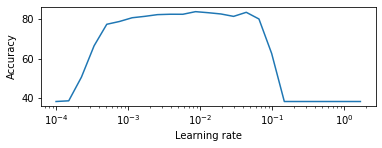

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(lr_, test_acc)
ax.set_xscale('log')
ax.set_xlabel("Learning rate")
ax.set_ylabel("Accuracy")

#Training the classifier with maxlr obtained above

In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0025)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.019, step_size_up=5, step_size_down=20, mode='triangular2')

In [11]:
import torch
from tqdm import tqdm
from Train_Test_utils.traine import train
from Train_Test_utils.teste import test
test_acc = []
train_acc = []
trainloss_ = []
testloss_ = []
lr_ = []
loss=1000
loss1= 1000
prev_loss1=1000
nn.Dropout2d
for epoch in range(50):  # loop over the dataset multiple times
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
      lr_.append(param_group['lr'])
    trainacc, loss = train(net, device, trainloader, optimizer, criterion, epoch)
    train_acc.append(trainacc)
    testacc, loss1 = test(net, device, testloader, criterion)
    test_acc.append(testacc)
    trainloss_.append(loss)
    testloss_.append(loss1)
    scheduler.step()
print('Finished Training')

  0%|          | 0/120 [00:00<?, ?it/s]

lr=  0.001


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 0 Loss=1.3609709739685059 Batch_id=12 Accuracy=39.84:  11%|█         | 13/120 [00:32<02:24,  1.35s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 0 Loss=1.3194009065628052 Batch_id=16 Accuracy=41.41:  14%|█▍        | 17/120 [00:41<02:18,  1.35s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 0 Loss=1.3156846761703491 Batch_id=20 Accuracy=38.28:  18%|█▊        | 21/120 [00:50<02:10,  1.32s/it]/

Test Loss= 0.67425984 Test Accuracy= 69.80584008561382
lr=  0.004600000000000003


Epoch= 1 Loss=0.9215365052223206 Batch_id=0 Accuracy=62.50:   1%|          | 1/120 [00:06<12:02,  6.07s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 1 Loss=0.6468055844306946 Batch_id=22 Accuracy=73.44:  19%|█▉        | 23/120 [00:56<03:00,  1.86s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed

Test Loss= 0.62802 Test Accuracy= 80.79804311267391
lr=  0.008200000000000006


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 2 Loss=0.5480962991714478 Batch_id=11 Accuracy=75.78:  10%|█         | 12/120 [00:32<03:29,  1.94s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 2 Loss=0.49276548624038696 Batch_id=13 Accuracy=82.03:  12%|█▏        | 14/120 [00:39<04:10,  2.37s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 2 Loss=0.4031776487827301 Batch_id=34 Accuracy=81.25:  29%|██▉       | 35/120 [01:36<02:30,  1.76s/it]

Test Loss= 0.6085486 Test Accuracy= 82.89252407888702
lr=  0.011800000000000008


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 3 Loss=0.4064115881919861 Batch_id=7 Accuracy=82.81:   7%|▋         | 8/120 [00:22<03:53,  2.08s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 3 Loss=0.3384590446949005 Batch_id=11 Accuracy=85.94:  10%|█         | 12/120 [00:36<03:36,  2.01s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed

Test Loss= 0.43405193 Test Accuracy= 81.97523314477908
lr=  0.01539999999999999


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 4 Loss=0.3362886309623718 Batch_id=3 Accuracy=88.28:   3%|▎         | 4/120 [00:14<09:23,  4.86s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 4 Loss=0.35834792256355286 Batch_id=7 Accuracy=86.72:   7%|▋         | 8/120 [00:26<05:20,  2.86s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 4 Loss=0.42650938034057617 Batch_id=23 Accuracy=82.81:  20%|██        | 24/120 [01:06<03:16,  2.05s/it]/us

Test Loss= 0.30753165 Test Accuracy= 82.8313713499465
lr=  0.018999999999999996


Epoch= 5 Loss=0.41113781929016113 Batch_id=0 Accuracy=82.03:   1%|          | 1/120 [00:07<14:49,  7.47s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 5 Loss=0.4422825574874878 Batch_id=7 Accuracy=80.47:   7%|▋         | 8/120 [00:18<03:06,  1.67s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed 

Test Loss= 0.54773265 Test Accuracy= 83.50405136829231
lr=  0.018099999999999998


Epoch= 6 Loss=0.39483505487442017 Batch_id=8 Accuracy=86.72:   8%|▊         | 9/120 [00:26<03:18,  1.79s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 6 Loss=0.35872822999954224 Batch_id=16 Accuracy=89.06:  14%|█▍        | 17/120 [00:43<02:06,  1.23s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 6 Loss=0.5019823908805847 Batch_id=24 Accuracy=82.81:  21%|██        | 25/120 [01:04<02:02,  1.29s/it]/

Test Loss= 0.67410475 Test Accuracy= 83.09127044794374
lr=  0.017199999999999997


Epoch= 7 Loss=0.35463762283325195 Batch_id=3 Accuracy=85.16:   3%|▎         | 4/120 [00:16<09:24,  4.86s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 7 Loss=0.30652981996536255 Batch_id=15 Accuracy=88.28:  13%|█▎        | 16/120 [00:43<02:45,  1.59s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 7 Loss=0.3184110224246979 Batch_id=39 Accuracy=89.84:  33%|███▎      | 40/120 [01:45<01:59,  1.49s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
E

Test Loss= 0.53530353 Test Accuracy= 82.57147225194925
lr=  0.016299999999999995


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 8 Loss=0.40281590819358826 Batch_id=3 Accuracy=85.16:   3%|▎         | 4/120 [00:09<05:58,  3.09s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 8 Loss=0.3544956147670746 Batch_id=5 Accuracy=86.72:   5%|▌         | 6/120 [00:18<06:49,  3.59s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to 

Test Loss= 0.15558584 Test Accuracy= 81.95994496254396
lr=  0.0154


Epoch= 9 Loss=0.37883642315864563 Batch_id=7 Accuracy=88.28:   7%|▋         | 8/120 [00:23<04:10,  2.24s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 9 Loss=0.39194241166114807 Batch_id=11 Accuracy=87.50:  10%|█         | 12/120 [00:35<03:10,  1.76s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 9 Loss=0.47513794898986816 Batch_id=15 Accuracy=81.25:  13%|█▎        | 16/120 [00:42<02:09,  1.25s/it]

Test Loss= 0.76291627 Test Accuracy= 83.7792386485247
lr=  0.014500000000000002


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 10 Loss=0.5720049738883972 Batch_id=7 Accuracy=77.34:   7%|▋         | 8/120 [00:28<05:51,  3.14s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 10 Loss=0.37621164321899414 Batch_id=9 Accuracy=85.94:   8%|▊         | 10/120 [00:34<05:05,  2.78s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 10 Loss=0.4396305978298187 Batch_id=71 Accuracy=80.47:  60%|██████    | 72/120 [03:01<01:25,  1.78s/it]

Test Loss= 0.8657796 Test Accuracy= 82.51031952300872
lr=  0.013600000000000001


Epoch= 11 Loss=0.42087915539741516 Batch_id=3 Accuracy=86.72:   3%|▎         | 4/120 [00:09<05:56,  3.07s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 11 Loss=0.3804757595062256 Batch_id=14 Accuracy=85.16:  12%|█▎        | 15/120 [00:33<02:31,  1.44s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 11 Loss=0.32253554463386536 Batch_id=18 Accuracy=89.06:  16%|█▌        | 19/120 [00:42<02:46,  1.65s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be 

Test Loss= 0.26448628 Test Accuracy= 83.7333741018193
lr=  0.0127


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 12 Loss=0.33672839403152466 Batch_id=15 Accuracy=87.50:  13%|█▎        | 16/120 [00:46<03:40,  2.12s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 12 Loss=0.30514010787010193 Batch_id=17 Accuracy=89.06:  15%|█▌        | 18/120 [00:52<04:32,  2.67s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 12 Loss=0.28773459792137146 Batch_id=37 Accuracy=88.28:  32%|███▏      | 38/120 [01:34<02:54,  2.13s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.p

Test Loss= 0.21562749 Test Accuracy= 81.82235132242776
lr=  0.011799999999999998


Epoch= 13 Loss=0.39120709896087646 Batch_id=7 Accuracy=80.47:   7%|▋         | 8/120 [00:22<03:57,  2.12s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 13 Loss=0.4437878727912903 Batch_id=11 Accuracy=83.59:  10%|█         | 12/120 [00:31<02:42,  1.51s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 13 Loss=0.3192923367023468 Batch_id=15 Accuracy=86.72:  13%|█▎        | 16/120 [00:38<01:59,  1.15s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "

Test Loss= 0.5785681 Test Accuracy= 83.62635682617336
lr=  0.010899999999999996


Epoch= 14 Loss=0.42258402705192566 Batch_id=3 Accuracy=82.03:   3%|▎         | 4/120 [00:11<07:23,  3.82s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 14 Loss=0.4529426395893097 Batch_id=24 Accuracy=78.91:  21%|██        | 25/120 [01:00<03:26,  2.17s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 14 Loss=0.3480779826641083 Batch_id=36 Accuracy=86.72:  31%|███       | 37/120 [01:32<03:33,  2.57s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:93

Test Loss= 0.7505274 Test Accuracy= 84.13086683993274
lr=  0.009999999999999998


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 15 Loss=0.31440579891204834 Batch_id=4 Accuracy=89.06:   4%|▍         | 5/120 [00:15<05:51,  3.06s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 15 Loss=0.3880976140499115 Batch_id=12 Accuracy=85.16:  11%|█         | 13/120 [00:40<03:27,  1.94s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 15 Loss=0.39822083711624146 Batch_id=28 Accuracy=88.28:  24%|██▍       | 29/120 [01:20<02:07,  1.40s/i

Test Loss= 0.6739791 Test Accuracy= 84.45191866687051
lr=  0.009099999999999997


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 16 Loss=0.2751169502735138 Batch_id=18 Accuracy=87.50:  16%|█▌        | 19/120 [00:56<03:11,  1.90s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 16 Loss=0.3287779688835144 Batch_id=24 Acc

Test Loss= 0.70903295 Test Accuracy= 84.32961320898946
lr=  0.008199999999999995


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 17 Loss=0.3653852343559265 Batch_id=16 Accuracy=82.81:  14%|█▍        | 17/120 [00:43<02:52,  1.67s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 17 Loss=0.28219860792160034 Batch_id=22 Accuracy=90.62:  19%|█▉        | 23/120 [00:58<03:07,  1.93s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Pa

Test Loss= 0.44058508 Test Accuracy= 83.24415227029506
lr=  0.0073


Epoch= 18 Loss=0.32333123683929443 Batch_id=23 Accuracy=89.06:  20%|██        | 24/120 [01:00<02:37,  1.64s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 18 Loss=0.3266614079475403 Batch_id=27 Accuracy=89.06:  23%|██▎       | 28/120 [01:09<02:04,  1.36s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 18 Loss=0.2978968322277069 Batch_id=35 Accuracy=88.28:  30%|███       | 36/120 [01:32<02:18,  1.65s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 18 Loss=0.34957316517829895 Batch_id=37 Accur

Test Loss= 0.27656895 Test Accuracy= 83.91683228864088
lr=  0.0063999999999999994


Epoch= 19 Loss=0.30560460686683655 Batch_id=6 Accuracy=91.41:   6%|▌         | 7/120 [00:17<04:01,  2.14s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 19 Loss=0.3030577003955841 Batch_id=7 Accuracy=89.06:   7%|▋         | 8/120 [00:20<04:27,  2.39s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 19 Loss=0.36550775170326233 Batch_id=10 Accuracy=86.72:   9%|▉         | 11/120 [00:24<02:57,  1.63s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 19 Loss=0.43553006649017334 Batch_id=12 Accuracy

Test Loss= 0.3533292 Test Accuracy= 84.25317229781379
lr=  0.005499999999999999


Epoch= 20 Loss=0.3450172543525696 Batch_id=4 Accuracy=88.28:   4%|▍         | 5/120 [00:18<08:07,  4.24s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 20 Loss=0.3036806285381317 Batch_id=17 Accuracy=89.06:  15%|█▌        | 18/120 [00:56<03:42,  2.18s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 20 Loss=0.29734301567077637 Batch_id=29 Accuracy=85.16:  25%|██▌       | 30/120 [01:23<01:50,  1.23s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "

Test Loss= 0.3745267 Test Accuracy= 84.46720684910564
lr=  0.004600000000000003


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 21 Loss=0.4135437309741974 Batch_id=4 Accuracy=82.81:   4%|▍         | 5/120 [00:20<08:15,  4.30s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 21 Loss=0.308562308549881 Batch_id=8 Accuracy=90.62:   8%|▊         | 9/120 [00:30<03:54,  2.11s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 21 Loss=0.4414517879486084 Batch_id=26 Accuracy=82.81:  22%|██▎       | 27/120 [01:15<03:01,  1.95s/it]/us

Test Loss= 0.66944784 Test Accuracy= 84.1155786576976
lr=  0.0037000000000000023


Epoch= 22 Loss=0.1949681043624878 Batch_id=3 Accuracy=90.62:   3%|▎         | 4/120 [00:13<08:39,  4.48s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 22 Loss=0.3384005129337311 Batch_id=19 Accuracy=85.94:  17%|█▋        | 20/120 [00:53<02:15,  1.36s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 22 Loss=0.3789953887462616 Batch_id=40 Accuracy=80.47:  34%|███▍      | 41/120 [01:45<02:12,  1.68s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss= 0.19402212 Test Accuracy= 83.93212047087601
lr=  0.0028000000000000013


Epoch= 23 Loss=0.30205038189888 Batch_id=3 Accuracy=89.84:   3%|▎         | 4/120 [00:12<08:07,  4.21s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 23 Loss=0.37927037477493286 Batch_id=11 Accuracy=80.47:  10%|█         | 12/120 [00:31<03:59,  2.22s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 23 Loss=0.25837329030036926 Batch_id=17 Accuracy=89.06:  15%|█▌        | 18/120 [00:49<04:37,  2.73s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss= 0.15351926 Test Accuracy= 84.6353768536921
lr=  0.0019000000000000006


Epoch= 24 Loss=0.2519387900829315 Batch_id=9 Accuracy=90.62:   8%|▊         | 10/120 [00:27<03:36,  1.97s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 24 Loss=0.3119504451751709 Batch_id=17 Accuracy=87.50:  15%|█▌        | 18/120 [00:50<02:43,  1.60s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 24 Loss=0.3381049633026123 Batch_id=33 Accuracy=89.06:  28%|██▊       | 34/120 [01:29<01:58,  1.37s/it

Test Loss= 0.3042388 Test Accuracy= 84.89527595168934
lr=  0.001


Epoch= 25 Loss=0.27746671438217163 Batch_id=11 Accuracy=86.72:  10%|█         | 12/120 [00:29<02:50,  1.58s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 25 Loss=0.27365005016326904 Batch_id=28 Accuracy=88.28:  24%|██▍       | 29/120 [01:18<04:12,  2.78s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 25 Loss=0.30218973755836487 Batch_id=44 Accuracy=87.50:  38%|███▊      | 45/120 [01:52<01:48,  1.44s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should 

Test Loss= 0.20952536 Test Accuracy= 84.69652958263262
lr=  0.0028000000000000013


Epoch= 26 Loss=0.3999946415424347 Batch_id=7 Accuracy=83.59:   7%|▋         | 8/120 [00:25<03:45,  2.02s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 26 Loss=0.35525596141815186 Batch_id=8 Accuracy=85.16:   8%|▊         | 9/120 [00:30<05:23,  2.91s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 26 Loss=0.3712165057659149 Batch_id=20 Accuracy=85.94:  18%|█▊        | 21/120 [00:54<02:09,  1.31s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
E

Test Loss= 0.4771956 Test Accuracy= 84.65066503592723
lr=  0.004600000000000003


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 27 Loss=0.437552809715271 Batch_id=3 Accuracy=84.38:   3%|▎         | 4/120 [00:11<07:10,  3.71s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 27 Loss=0.29413020610809326 Batch_id=5 Accuracy=88.28:   5%|▌         | 6/120 [00:16<05:41,  2.99s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 27 Loss=0.3337286412715912 Batch_id=6 Accuracy=87.50:   6%|▌         | 7/120 [00:18<05:05,  2.70s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: Us

Test Loss= 0.88877815 Test Accuracy= 84.26846048004892
lr=  0.006400000000000005


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 28 Loss=0.3104724586009979 Batch_id=4 Accuracy=89.06:   4%|▍         | 5/120 [00:11<03:46,  1.97s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 28 Loss=0.5324103832244873 Batch_id=20 Accuracy=82.81:  18%|█▊        | 21/120 [00:55<03:40,  2.23s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palet

Test Loss= 0.26808083 Test Accuracy= 82.61733679865463
lr=  0.008200000000000006


Epoch= 29 Loss=0.4963030517101288 Batch_id=4 Accuracy=79.69:   4%|▍         | 5/120 [00:18<07:22,  3.84s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 29 Loss=0.34557732939720154 Batch_id=7 Accuracy=87.50:   7%|▋         | 8/120 [00:24<04:24,  2.36s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 29 Loss=0.34645965695381165 Batch_id=24 Accuracy=83.59:  21%|██        | 25/120 [01:17<03:49,  2.41s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 29 Loss=0.2947021424770355 Batch_id=40 Accuracy=

Test Loss= 0.44494992 Test Accuracy= 84.03913774652194
lr=  0.009999999999999998


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 30 Loss=0.367799311876297 Batch_id=8 Accuracy=90.62:   8%|▊         | 9/120 [00:25<04:28,  2.42s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 30 Loss=0.31301361322402954 Batch_id=24 Accuracy=91.41:  21%|██        | 25/120 [01:06<01:50,  1.16s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 30 Loss=0.2781357765197754 Batch_id=30 Accuracy=89.84:  26%|██▌       | 31/120 [01:21<02:56,  1.99s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932

Test Loss= 0.13363193 Test Accuracy= 84.62008867145697
lr=  0.009549999999999996


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 31 Loss=0.35015109181404114 Batch_id=3 Accuracy=87.50:   3%|▎         | 4/120 [00:13<07:55,  4.10s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 31 Loss=0.3828616142272949 Batch_id=57 Accuracy=85.16:  48%|████▊     | 58/120 [02:27<01:12,  1.17s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 31 Loss=0.40135523676872253 Batch_id=70 Accuracy=83.59:  59%|█████▉    | 71/120 [03:05<02:49,  3.46s/i

Test Loss= 0.7400395 Test Accuracy= 84.06971411099221
lr=  0.009099999999999997


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 32 Loss=0.3256778120994568 Batch_id=2 Accuracy=87.50:   2%|▎         | 3/120 [00:08<07:10,  3.68s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 32 Loss=0.27385103702545166 Batch_id=13 Accuracy=89.84:  12%|█▏        | 14/120 [00:33<02:38,  1.49s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 32 Loss=0.2697892487049103 Batch_id=48 Accuracy=88.28:  41%|████      | 49/120 [02:07<01:31,  1.28s/it

Test Loss= 0.45206815 Test Accuracy= 84.46720684910564
lr=  0.008649999999999996


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 33 Loss=0.3728611171245575 Batch_id=3 Accuracy=89.06:   3%|▎         | 4/120 [00:15<10:17,  5.33s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 33 Loss=0.23769675195217133 Batch_id=7 Accuracy=92.97:   7%|▋         | 8/120 [00:24<04:16,  2.29s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 33 Loss=0.36354339122772217 Batch_id=23 Accuracy=86.72:  20%|██        | 24/120 [01:02<02:14,  1.40s/it]

Test Loss= 0.6058018 Test Accuracy= 83.68750955511389
lr=  0.008199999999999995


Epoch= 34 Loss=0.39214715361595154 Batch_id=0 Accuracy=86.72:   1%|          | 1/120 [00:12<23:55, 12.06s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 34 Loss=0.25007086992263794 Batch_id=4 Accuracy=91.41:   4%|▍         | 5/120 [00:19<08:17,  4.33s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting 

Test Loss= 0.23798722 Test Accuracy= 83.85567955970035
lr=  0.007750000000000001


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 35 Loss=0.28311923146247864 Batch_id=7 Accuracy=89.06:   7%|▋         | 8/120 [00:23<04:12,  2.25s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 35 Loss=0.29420924186706543 Batch_id=11 Accuracy=86.72:  10%|█         | 12/120 [00:32<02:48,  1.56s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 35 Loss=0.42566657066345215 Batch_id=47 Accuracy=83.59:  40%|████      | 48/120 [02:07<01:48,  1.51s/

Test Loss= 0.4293097 Test Accuracy= 84.26846048004892
lr=  0.0073


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 36 Loss=0.2984362840652466 Batch_id=4 Accuracy=86.72:   4%|▍         | 5/120 [00:19<07:59,  4.17s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 36 Loss=0.37077397108078003 Batch_id=16 Accuracy=89.84:  14%|█▍        | 17/120 [00:46<03:01,  1.76s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting

Test Loss= 0.6639543 Test Accuracy= 84.80354685827855
lr=  0.00685


Epoch= 37 Loss=0.3358643352985382 Batch_id=19 Accuracy=86.72:  17%|█▋        | 20/120 [00:46<02:08,  1.29s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 37 Loss=0.42026081681251526 Batch_id=23 Accuracy=85.94:  20%|██        | 24/120 [00:57<02:14,  1.41s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 37 Loss=0.3970535099506378 Batch_id=31 Accuracy=84.38:  27%|██▋       | 32/120 [01:13<01:47,  1.22s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be

Test Loss= 0.5956224 Test Accuracy= 84.39076593792998
lr=  0.0063999999999999994


Epoch= 38 Loss=0.4128265082836151 Batch_id=4 Accuracy=86.72:   4%|▍         | 5/120 [00:15<06:43,  3.50s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 38 Loss=0.34522804617881775 Batch_id=7 Accuracy=85.94:   7%|▋         | 8/120 [00:22<04:05,  2.19s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 38 Loss=0.42446303367614746 Batch_id=23 Accuracy=86.72:  20%|██        | 24/120 [00:58<02:27,  1.53s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss= 0.39221743 Test Accuracy= 84.43663048463537
lr=  0.005949999999999999


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 39 Loss=0.3827952444553375 Batch_id=7 Accuracy=83.59:   7%|▋         | 8/120 [00:19<03:21,  1.80s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 39 Loss=0.3936658799648285 Batch_id=84 Accur

Test Loss= 0.373689 Test Accuracy= 84.45191866687051
lr=  0.005499999999999999


Epoch= 40 Loss=0.4153168201446533 Batch_id=7 Accuracy=85.94:   7%|▋         | 8/120 [00:21<03:18,  1.78s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 40 Loss=0.2816503643989563 Batch_id=13 Accuracy=89.06:  12%|█▏        | 14/120 [00:37<03:15,  1.85s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 40 Loss=0.3252473473548889 Batch_id=23 Accuracy=85.94:  20%|██        | 24/120 [00:56<02:05,  1.31s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss= 0.33844182 Test Accuracy= 83.68750955511389
lr=  0.005050000000000003


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 41 Loss=0.43883368372917175 Batch_id=3 Accuracy=82.03:   3%|▎         | 4/120 [00:12<08:11,  4.24s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 41 Loss=0.2697540819644928 Batch_id=7 Accuracy=85.94:   7%|▋         | 8/120 [00:20<03:37,  1.95s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 41 Loss=0.3103579580783844 Batch_id=10 Accuracy=89.84:   9%|▉         | 11/120 [00:31<04:08,  2.28s/it]/

Test Loss= 0.2723347 Test Accuracy= 85.03286959180554
lr=  0.004600000000000003


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 42 Loss=0.3030339479446411 Batch_id=7 Accuracy=89.06:   7%|▋         | 8/120 [00:22<04:11,  2.25s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 42 Loss=0.25724735856056213 Batch_id=14 Accuracy=91.41:  12%|█▎        | 15/120 [00:40<03:26,  1.97s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expres

Test Loss= 0.589349 Test Accuracy= 84.20730775110839
lr=  0.004150000000000003


Epoch= 43 Loss=0.34730803966522217 Batch_id=6 Accuracy=84.38:   6%|▌         | 7/120 [00:19<04:40,  2.48s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 43 Loss=0.40115880966186523 Batch_id=7 Accuracy=85.16:   7%|▋         | 8/120 [00:22<04:44,  2.54s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 43 Loss=0.4417344629764557 Batch_id=27 Accuracy=84.38:  23%|██▎       | 28/120 [01:12<01:46,  1.16s/it]

Test Loss= 0.70460165 Test Accuracy= 83.53462773276257
lr=  0.0037000000000000023


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 44 Loss=0.2853126525878906 Batch_id=0 Accuracy=87.50:   1%|          | 1/120 [00:12<24:10, 12.19s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 44 Loss=0.5659752488136292 Batch_id=7 Accuracy=78.12:   7%|▋         | 8/120 [00:22<03:45,  2.01s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 44 Loss=0.42175009846687317 Batch_id=30 Accuracy=83.59:  26%|██▌       | 31/120 [01:26<03:16,  2.21s/it]/

Test Loss= 1.3091439 Test Accuracy= 84.36018957345972
lr=  0.003250000000000002


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 45 Loss=0.32796987891197205 Batch_id=7 Accuracy=85.16:   7%|▋         | 8/120 [00:23<04:28,  2.40s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 45 Loss=0.2622464895248413 Batch_id=11 Accuracy=92.19:  10%|█         | 12/120 [00:32<04:01,  2.23s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 45 Loss=0.307473748922348 Batch_id=15 Accuracy=85.94:  13%|█▎        | 16/120 [00:42<03:28,  2.01s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932

Test Loss= 0.40726346 Test Accuracy= 84.94114049839474
lr=  0.0028000000000000013


Epoch= 46 Loss=0.44960662722587585 Batch_id=3 Accuracy=84.38:   3%|▎         | 4/120 [00:14<07:24,  3.83s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 46 Loss=0.3684398829936981 Batch_id=7 Accuracy=86.72:   7%|▋         | 8/120 [00:28<04:30,  2.42s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 46 Loss=0.33552369475364685 Batch_id=47 Accuracy=85.94:  40%|████      | 48/120 [01:58<01:47,  1.50s/it]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Epoch= 46 Loss=0.28128331899642944 Batch_id=54 Accuracy

Test Loss= 0.16977763 Test Accuracy= 84.75768231157315
lr=  0.0023500000000000014


Epoch= 47 Loss=0.29757407307624817 Batch_id=12 Accuracy=89.06:  11%|█         | 13/120 [00:38<03:47,  2.13s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 47 Loss=0.3119104504585266 Batch_id=22 Accuracy=86.72:  19%|█▉        | 23/120 [01:01<03:53,  2.41s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 47 Loss=0.27912259101867676 Batch_id=25 Accuracy=89.84:  22%|██▏       | 26/120 [01:08<02:54,  1.86s

Test Loss= 0.34354335 Test Accuracy= 84.9258523161596
lr=  0.0019000000000000006


Epoch= 48 Loss=0.3610494136810303 Batch_id=7 Accuracy=84.38:   7%|▋         | 8/120 [00:25<05:56,  3.18s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 48 Loss=0.24942666292190552 Batch_id=8 Accuracy=91.41:   8%|▊         | 9/120 [00:27<04:50,  2.62s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 48 Loss=0.3204861283302307 Batch_id=17 Accuracy=87.50:  15%|█▌        | 18/120 [00:48<03:00,  1.77s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
E

Test Loss= 0.31023172 Test Accuracy= 84.74239412933802
lr=  0.0014500000000000003


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 49 Loss=0.3424089550971985 Batch_id=4 Accuracy=85.16:   4%|▍         | 5/120 [00:14<07:06,  3.71s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 49 Loss=0.2658708691596985 Batch_id=16 Accuracy=90.62:  14%|█▍        | 17/120 [00:42<02:28,  1.44s/it]/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Epoch= 49 Loss=0.3476724624633789 Batch_id=28 Accuracy=86.72:  24%|██▍       | 29/120 [01:10<01:57,  1.30s/it]

Test Loss= 0.08027541 Test Accuracy= 84.32961320898946
Finished Training


#Save Model

In [12]:
torch.save(net.state_dict(), 'Generated_models/Model.pth')
#modelnet.eval()

#Lr vs Epoch plot 

Text(0, 0.5, 'Epoch')

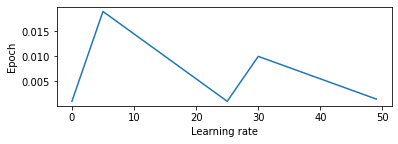

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(lr_)
ax.set_xlabel("Learning rate")
ax.set_ylabel("Epoch")

#Plot Train/Test Accuracy and loss

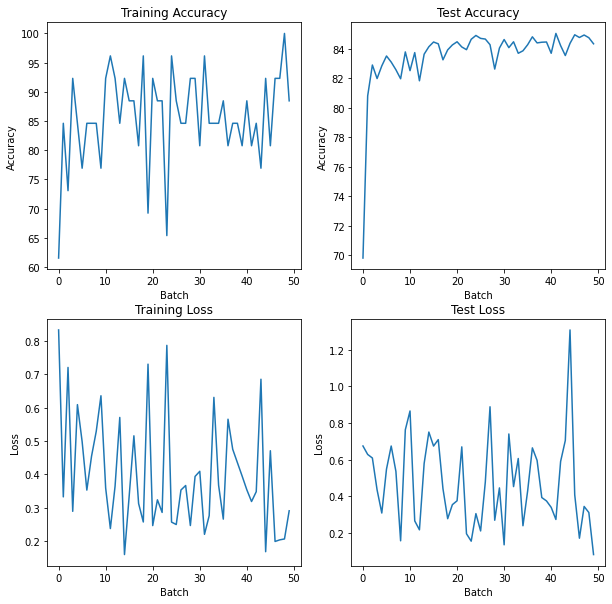

In [13]:
general_utils.plot_acc_loss(train_acc, test_acc, trainloss_, testloss_)

#Load Model

In [19]:
device = torch.device("cuda" if cudas.cuda else "cpu")
modelnet = mobilenetv2().to(device)
modelnet.load_state_dict(torch.load('Model.pth'))

<All keys matched successfully>

#Groundtruth vs Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT    Large QuadCopters      Small QuadCopters      Winged Drones      Large QuadCopters
Pred  Flying Birds      Small QuadCopters      Flying Birds      Large QuadCopters


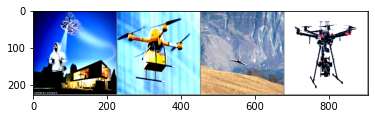

In [20]:
import numpy
dataiter = iter(testloader1)
images, labels = dataiter.next()

# print images
general_utils.imshow(torchvision.utils.make_grid(images))
print('GT   ', '      '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = modelnet(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Pred ', '      '.join('%5s' % classes[predicted[j].cpu().data.numpy()] for j in range(4)))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT    Large QuadCopters      Small QuadCopters      Flying Birds      Flying Birds
Pred  Winged Drones      Winged Drones      Flying Birds      Flying Birds


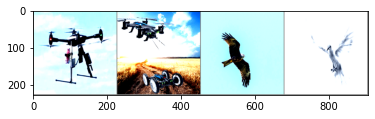

In [22]:
dataiter = iter(testloader1)
images, labels = dataiter.next()
# print images
general_utils.imshow(torchvision.utils.make_grid(images))
print('GT   ', '      '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = modelnet(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Pred ', '      '.join('%5s' % classes[predicted[j].cpu().data.numpy()] for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT    Flying Birds      Flying Birds      Winged Drones      Large QuadCopters
Pred  Flying Birds      Flying Birds      Winged Drones      Large QuadCopters


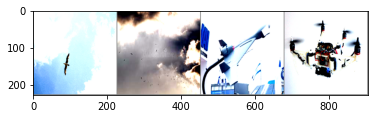

In [23]:
dataiter = iter(testloader1)
images, labels = dataiter.next()
# print images
general_utils.imshow(torchvision.utils.make_grid(images))
print('GT   ', '      '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = modelnet(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Pred ', '      '.join('%5s' % classes[predicted[j].cpu().data.numpy()] for j in range(4)))